In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


In [ ]:
# ver1では一旦無視
# Ranking学習の場合、Taregetの数字を変える
# 1を1に、0を2に変える
# train_label['target'] = train_label['target'].replace(0, 2)

### LightGBM Ranker（candidate用のRankerモデル）

In [8]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')] # seen_yadも入れる
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# LightGBM のパラメータ
params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': [3, 5, 10],
    # 'label_gain':"0,1,5",　# ここを指定すると、ターゲットの重み付けができる　https://blog.recruit.co.jp/data/articles/lgbm_rank/
    'boosting_type': 'dart',
    'learning_rate': 0.1,
    'n_estimators' : 1000,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

In [9]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score

map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # クエリごとのデータポイント数を計算
    train_groups = train_data.groupby(query_ids).size().values
    val_groups = valid_data.groupby(query_ids).size().values

    # LightGBMデータセットを作成
    lgb_train = lgb.Dataset(train_data[features], label=train_data[target], group=train_groups)
    lgb_val = lgb.Dataset(valid_data[features], label=valid_data[target], group=val_groups)

    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=100, verbose_eval=1)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(valid_data[features])
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')

[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.75312	valid_0's map@5: 0.768522	valid_0's map@10: 0.785229
[2]	valid_0's map@3: 0.752661	valid_0's map@5: 0.768222	valid_0's map@10: 0.784829
[3]	valid_0's map@3: 0.756272	valid_0's map@5: 0.771763	valid_0's map@10: 0.787857
[4]	valid_0's map@3: 0.757159	valid_0's map@5: 0.772293	valid_0's map@10: 0.788492
[5]	valid_0's map@3: 0.758475	valid_0's map@5: 0.773864	valid_0's map@10: 0.789784
[6]	valid_0's map@3: 0.758608	valid_0's map@5: 0.77406	valid_0's map@10: 0.789897
[7]	valid_0's map@3: 0.75871

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.75024	valid_0's map@5: 0.766316	valid_0's map@10: 0.782996


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	valid_0's map@3: 0.754105	valid_0's map@5: 0.769791	valid_0's map@10: 0.786364
[3]	valid_0's map@3: 0.753799	valid_0's map@5: 0.769471	valid_0's map@10: 0.785869
[4]	valid_0's map@3: 0.755219	valid_0's map@5: 0.771008	valid_0's map@10: 0.787289
[5]	valid_0's map@3: 0.755782	valid_0's map@5: 0.771804	valid_0's map@10: 0.787838
[6]	valid_0's map@3: 0.754973	valid_0's map@5: 0.771528	valid_0's map@10: 0.787367
[7]	valid_0's map@3: 0.755132	valid_0's map@5: 0.771435	valid_0's map@10: 0.787492
[8]	valid_0's map@3: 0.756541	valid_0's map@5: 0.772613	valid_0's map@10: 0.788636
[9]	valid_0's map@3: 0.756977	valid_0's map@5: 0.773098	valid_0's map@10: 0.789005
[10]	valid_0's map@3: 0.757358	valid_0's map@5: 0.773657	valid_0's map@10: 0.789502
[11]	valid_0's map@3: 0.758094	valid_0's map@5: 0.774127	valid_0's map@10: 0.789994
[12]	valid_0's map@3: 0.758094	valid_0's map@5: 0.774127	valid_0's map@10: 0.789994
[13]	valid_0's map@3: 0.758703	valid_0's map@5: 0.774633	valid_0's map@10: 0.790332


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747201	valid_0's map@5: 0.763508	valid_0's map@10: 0.780537


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	valid_0's map@3: 0.754447	valid_0's map@5: 0.769997	valid_0's map@10: 0.786363
[3]	valid_0's map@3: 0.752799	valid_0's map@5: 0.768843	valid_0's map@10: 0.785202
[4]	valid_0's map@3: 0.7541	valid_0's map@5: 0.770163	valid_0's map@10: 0.786427
[5]	valid_0's map@3: 0.753737	valid_0's map@5: 0.769661	valid_0's map@10: 0.786043
[6]	valid_0's map@3: 0.754366	valid_0's map@5: 0.770343	valid_0's map@10: 0.786667
[7]	valid_0's map@3: 0.754862	valid_0's map@5: 0.770785	valid_0's map@10: 0.787027
[8]	valid_0's map@3: 0.755757	valid_0's map@5: 0.771298	valid_0's map@10: 0.787635
[9]	valid_0's map@3: 0.756043	valid_0's map@5: 0.771797	valid_0's map@10: 0.787967
[10]	valid_0's map@3: 0.756138	valid_0's map@5: 0.771973	valid_0's map@10: 0.788107
[11]	valid_0's map@3: 0.756508	valid_0's map@5: 0.772118	valid_0's map@10: 0.7882
[12]	valid_0's map@3: 0.756508	valid_0's map@5: 0.772118	valid_0's map@10: 0.7882
[13]	valid_0's map@3: 0.75671	valid_0's map@5: 0.772347	valid_0's map@10: 0.788395
[14]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750512	valid_0's map@5: 0.766154	valid_0's map@10: 0.783182


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	valid_0's map@3: 0.756184	valid_0's map@5: 0.771438	valid_0's map@10: 0.787663
[3]	valid_0's map@3: 0.756248	valid_0's map@5: 0.771934	valid_0's map@10: 0.788029
[4]	valid_0's map@3: 0.758075	valid_0's map@5: 0.773803	valid_0's map@10: 0.789632
[5]	valid_0's map@3: 0.758976	valid_0's map@5: 0.774488	valid_0's map@10: 0.790207
[6]	valid_0's map@3: 0.759311	valid_0's map@5: 0.774894	valid_0's map@10: 0.790606
[7]	valid_0's map@3: 0.758791	valid_0's map@5: 0.774365	valid_0's map@10: 0.790162
[8]	valid_0's map@3: 0.759111	valid_0's map@5: 0.774671	valid_0's map@10: 0.790432
[9]	valid_0's map@3: 0.75832	valid_0's map@5: 0.774311	valid_0's map@10: 0.79004
[10]	valid_0's map@3: 0.758759	valid_0's map@5: 0.774571	valid_0's map@10: 0.790336
[11]	valid_0's map@3: 0.759334	valid_0's map@5: 0.775099	valid_0's map@10: 0.790719
[12]	valid_0's map@3: 0.759342	valid_0's map@5: 0.775107	valid_0's map@10: 0.790727
[13]	valid_0's map@3: 0.759989	valid_0's map@5: 0.775516	valid_0's map@10: 0.791148
[1

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.748765	valid_0's map@5: 0.764573	valid_0's map@10: 0.781601


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	valid_0's map@3: 0.74989	valid_0's map@5: 0.765752	valid_0's map@10: 0.782771
[3]	valid_0's map@3: 0.752148	valid_0's map@5: 0.768323	valid_0's map@10: 0.784663
[4]	valid_0's map@3: 0.754641	valid_0's map@5: 0.77045	valid_0's map@10: 0.786666
[5]	valid_0's map@3: 0.754797	valid_0's map@5: 0.770692	valid_0's map@10: 0.78666
[6]	valid_0's map@3: 0.755617	valid_0's map@5: 0.771635	valid_0's map@10: 0.787463
[7]	valid_0's map@3: 0.755551	valid_0's map@5: 0.771554	valid_0's map@10: 0.787478
[8]	valid_0's map@3: 0.755701	valid_0's map@5: 0.771597	valid_0's map@10: 0.787538
[9]	valid_0's map@3: 0.756304	valid_0's map@5: 0.772032	valid_0's map@10: 0.787955
[10]	valid_0's map@3: 0.756829	valid_0's map@5: 0.772358	valid_0's map@10: 0.788384
[11]	valid_0's map@3: 0.756639	valid_0's map@5: 0.772349	valid_0's map@10: 0.788298
[12]	valid_0's map@3: 0.756639	valid_0's map@5: 0.772349	valid_0's map@10: 0.788298
[13]	valid_0's map@3: 0.756466	valid_0's map@5: 0.772162	valid_0's map@10: 0.78814
[14]

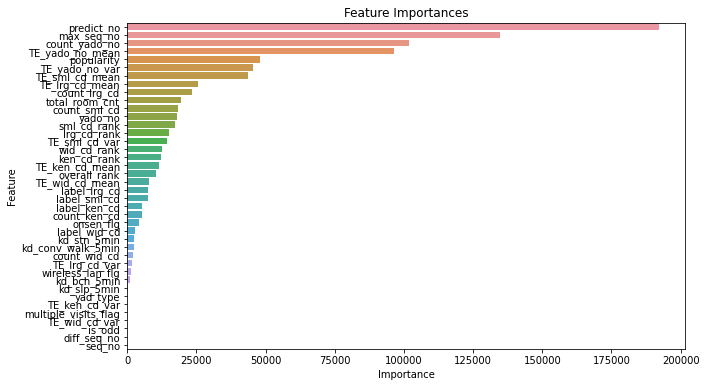

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importance(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [11]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [12]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.452745
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.204716
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.288503
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.692414
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.684854


In [13]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.452745
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.204716
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.288503
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.692414
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.684854
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-4.181851
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-4.627646
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-3.995290
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-4.869160


In [14]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.452745
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.204716
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.288503
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.692414
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.684854
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-4.181851
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-4.627646
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-3.995290
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-4.869160


In [15]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/lgbRanker_ver11_oof_pred.csv', index=False)

In [16]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.452745
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.204716
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.288503
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.692414
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.684854
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-4.181851
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-4.627646
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-3.995290
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-4.869160


### CVの計算

In [17]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [18]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [20]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 5490, 11380, 1284, 254, 4072, 12491]
CPU times: user 410 µs, sys: 1e+03 ns, total: 411 µs
Wall time: 428 µs


In [21]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:50<00:00, 5767.21it/s]


In [22]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,11882,5289,997,12846,3324,9208,9207,9209
1,8253,4488,8747,1586,3564,3725,2259,8225,11104,2570
2,4863,4355,9039,6722,7509,5238,1967,11724,13642,2957
3,626,13549,2272,7812,11715,755,109,1341,13296,7872
4,96,3894,7749,902,5490,11380,1284,254,4072,12491
...,...,...,...,...,...,...,...,...,...,...
288693,13079,13210,10955,3725,10522,5719,1586,8677,13717,2876
288694,513,963,4767,8703,2900,6654,5299,399,3940,8465
288695,10364,7308,12240,4040,2087,4398,7820,3566,9558,844
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


### 要素の集合にバグがないかを確認

In [23]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [24]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムの数を確認する

In [25]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [27]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0          True
1          True
2          True
3          True
4          True
          ...  
288693     True
288694     True
288695     True
288696    False
288697     True
Length: 288698, dtype: bool
一致していない行：
284637


In [28]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [29]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,11882,5289,997,12846,3324,9208,9207,9209
1,8253,4488,8747,1586,3564,3725,2259,8225,11104,2570
2,4863,4355,9039,6722,7509,5238,1967,11724,13642,2957
3,626,13549,2272,7812,11715,755,109,1341,13296,7872
4,96,3894,7749,902,5490,11380,1284,254,4072,12491
5,10510,4823,12544,5369,9207,9199,9202,9201,1,9200
6,12774,7531,2282,13240,441,2480,10378,7273,10442,4574
7,111,10544,4744,10362,12962,7681,12125,1755,12464,9508
8,899,3644,1227,3802,13220,4014,12432,9723,2164,13702
9,3278,10478,3483,6592,9773,379,550,2806,4303,9430


In [30]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [31]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [32]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.43473197454537826


In [33]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [34]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [35]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,4101,2808,11882,5289,997,12846,3324,9208,9207,9209,False
1,8253,4488,8747,1586,3564,3725,2259,8225,11104,2570,False
2,4863,4355,9039,6722,7509,5238,1967,11724,13642,2957,False
3,626,13549,2272,7812,11715,755,109,1341,13296,7872,False
4,96,3894,7749,902,5490,11380,1284,254,4072,12491,False


### 推論用の候補テーブル作成

In [36]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [37]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.36212313 -0.46084417 -0.37173088 ... -0.2058271  -0.25961449
 -0.17108479]
1683604


In [38]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [39]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [40]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.362123
1,00001149e9c73985425197104712478c,4714,-0.460844
2,00001149e9c73985425197104712478c,2680,-0.371731
3,00001149e9c73985425197104712478c,4420,-1.141459
4,00001149e9c73985425197104712478c,5466,-0.871841


In [41]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.362123
1,00001149e9c73985425197104712478c,4714,-0.460844
2,00001149e9c73985425197104712478c,2680,-0.371731
3,00001149e9c73985425197104712478c,4420,-1.141459
4,00001149e9c73985425197104712478c,5466,-0.871841
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.147767
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.144040
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.205827
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.259614


In [42]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.362123
1,00001149e9c73985425197104712478c,4714,-0.460844
2,00001149e9c73985425197104712478c,2680,-0.371731
3,00001149e9c73985425197104712478c,4420,-1.141459
4,00001149e9c73985425197104712478c,5466,-0.871841
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.147767
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.144040
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.205827
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.259614


In [44]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.362123
1,00001149e9c73985425197104712478c,4714,-0.460844
2,00001149e9c73985425197104712478c,2680,-0.371731
3,00001149e9c73985425197104712478c,4420,-1.141459
4,00001149e9c73985425197104712478c,5466,-0.871841
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.147767
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.144040
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.205827
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.259614


In [45]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/lgbRanker_ver11_test_pred.csv', index=False)

In [46]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [48]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[10729, 12767, 11723, 1891, 3781, 5623, 867, 12620, 11994, 634]
CPU times: user 541 µs, sys: 0 ns, total: 541 µs
Wall time: 514 µs


In [49]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:29<00:00, 5858.74it/s]


In [50]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,5466,4420,9830,9534,5785,6563
1,8108,7014,613,4066,6129,6555,143,11923,11237,12862
2,757,9190,7710,9910,1774,6721,10485,410,6730,13570
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,12029,10826,3476,9623,3854,9020,2862,5372,3844,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,10042,3440,9743
174696,899,13702,13220,3802,1227,3644,4014,12432,9723,2164
174697,12939,7308,2087,13719,13797,13241,11037,11796,8143,5810
174698,2373,3002,4976,10287,3100,13672,2692,1687,12281,5513


In [51]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [52]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [53]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [54]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


In [55]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [56]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,5466,4420,9830,9534,5785,6563,False
1,8108,7014,613,4066,6129,6555,143,11923,11237,12862,False
2,757,9190,7710,9910,1774,6721,10485,410,6730,13570,False
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489,False
4,12029,10826,3476,9623,3854,9020,2862,5372,3844,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,10042,3440,9743,False
174696,899,13702,13220,3802,1227,3644,4014,12432,9723,2164,False
174697,12939,7308,2087,13719,13797,13241,11037,11796,8143,5810,False
174698,2373,3002,4976,10287,3100,13672,2692,1687,12281,5513,False


In [57]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/lgbRanker_ver11.csv', index=False)